In [81]:
# imports
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler

# SMOTE
from imblearn.over_sampling import RandomOverSampler, SMOTE

## Utility Functions

In [82]:
def class_train_test_split(df, target, test_size=0.2, random_state=None):

    # Split the DataFrame into X (features) and y (target variable)
    X = df.drop(target, axis=1)
    y = df[target]

    # Perform the train-test split with shuffling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    return X_train, X_test, y_train, y_test

def result_metrics(y_test, preds):
    precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
    auc = roc_auc_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    print(f"Accuracy is: {accuracy:.2f}")
    print(f"Precision is: {precision:.2f}")
    print(f"Recall is: {recall:.2f}")
    print(f"Fscore is: {f_beta:.2f}")
    print(f"AUC is: {auc:.2f}")
    return

## Import and Clean Data

In [83]:
data = pd.read_csv('Churn_Modelling.csv', sep=',')
data1 = data

In [84]:
df_size = data.shape
print(f'Rows: {df_size[0]} Columns: {df_size[1]}')
print(data.columns)

Rows: 10000 Columns: 14
Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


In [85]:
# check for duplicated customers and drop them if duplicated
data.drop_duplicates(subset=['CustomerId'], keep='first', inplace=True)

# drop any NaN values
data.dropna(inplace=True)

In [86]:
# remove unecessary columns
remove_cols = ['RowNumber','CustomerId','Surname']
data.drop(columns=remove_cols, inplace=True)

In [87]:
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [88]:
# checking data types
data_types = data.dtypes
print(data_types)

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


In [89]:
# Checking unique columns
print(data['Geography'].unique())
print(data['Gender'].unique())

['France' 'Spain' 'Germany']
['Female' 'Male']


In [90]:
# One hot encoding for data preprocessing
# Map 'Gender' to 0 and 1
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
# one hot encoding for Geographic locations
data = pd.get_dummies(data, columns=['Geography'], drop_first=False)

In [91]:
data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,39,5,0.00,2,1,0,96270.64,0,1,0,0
9996,516,0,35,10,57369.61,1,1,1,101699.77,0,1,0,0
9997,709,1,36,7,0.00,1,0,1,42085.58,1,1,0,0
9998,772,0,42,3,75075.31,2,1,0,92888.52,1,0,1,0


In [92]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Gender,10000.0,0.454300,0.497932,0.00,0.00,0.000,1.0000,1.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


## Exploratory Data Analysis

In [93]:
# Plotting Functions
## Plot a histogram
def plot_hist(df, name, nbins=30):
    sns.histplot(data=df, x=name, bins=nbins, kde=True)
    plt.xlabel('Balance')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {name}')
    plt.show()
    return

## Box Plot
def plot_box(df,name):
    sns.boxplot(data=df, y=name)
    plt.ylabel(name)
    plt.title(f'Box Plot of {name}')
    plt.show()
    return

## Violin plot
def plot_violin(df,name):
    sns.violinplot(data=df, y=name)
    plt.ylabel(name)
    plt.title(f'Violin Plot on {name}')
    plt.show()
    return

## Kernel Density Estimation Plot (KDE)
def plot_KDE(df,name, target):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x=name, hue=target, fill=True, common_norm=False, palette='Set1')
    plt.xlabel(name)
    plt.ylabel('Density')
    plt.title(f'KDE Plot of {target} by {name}')
    plt.legend(title=target, labels=[f'Not {target}', target])
    plt.show()
    return

## Plot all
def plot_all(df,name,target,nbins=30):
    plot_hist(df,name,nbins=nbins)
    plot_box(df,name)
    plot_violin(df,name)
    plot_KDE(df,name,target)
    return

In [94]:
# looking at header and choosing columns I am interested in
header = data.columns
print(header)

interested_columns = ['CreditScore','Age', 'Tenure', 'Balance', 
                      'NumOfProducts','EstimatedSalary']

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype='object')


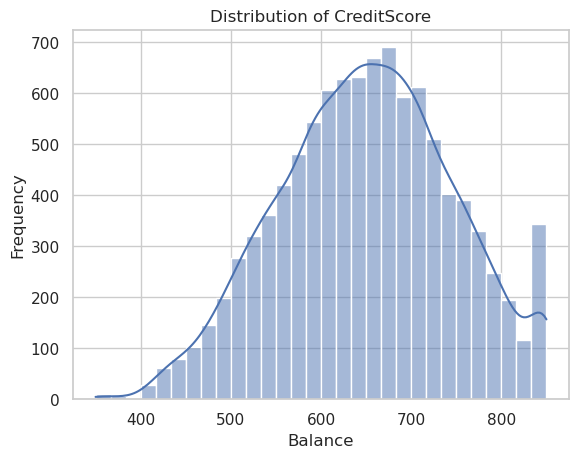

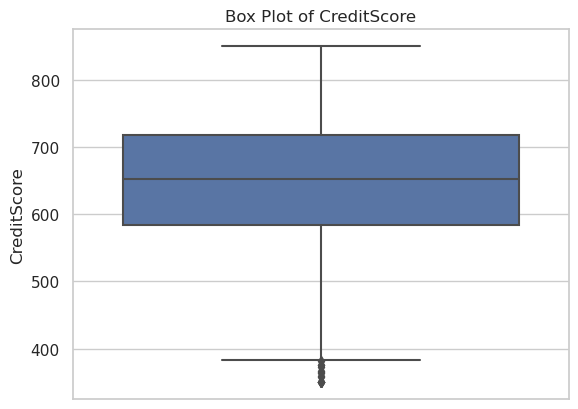

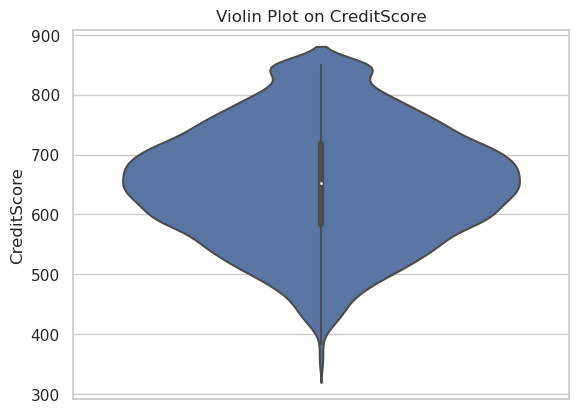

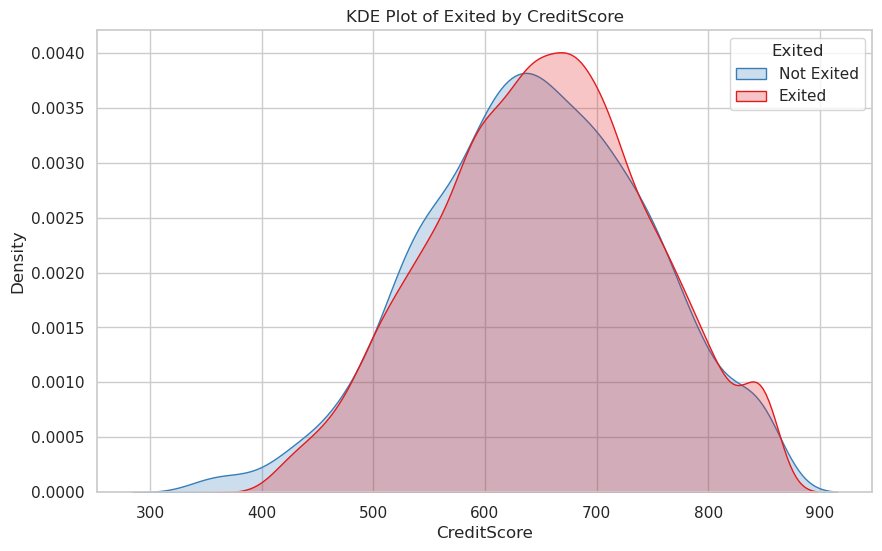

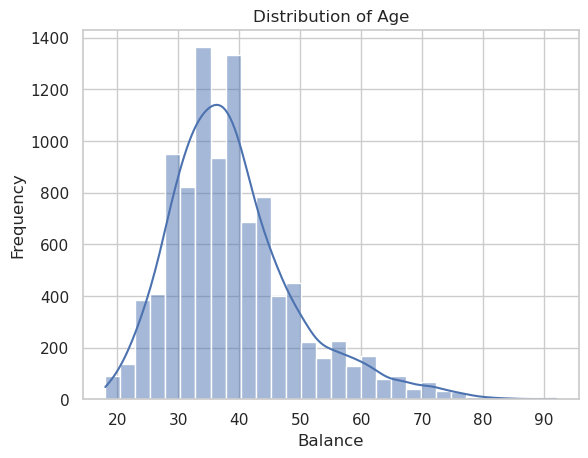

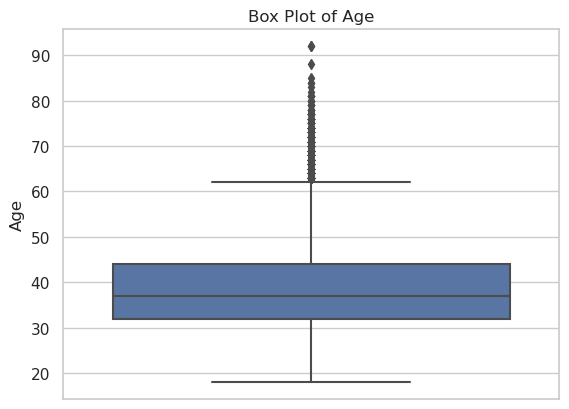

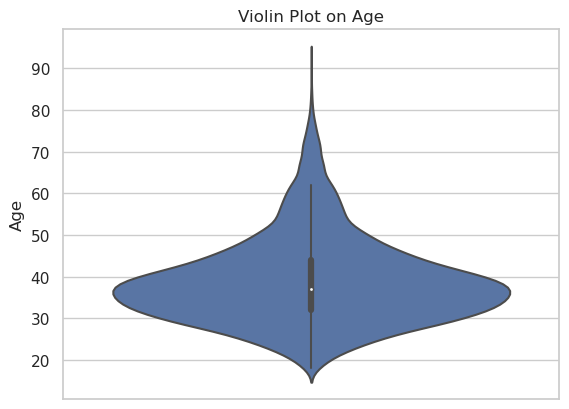

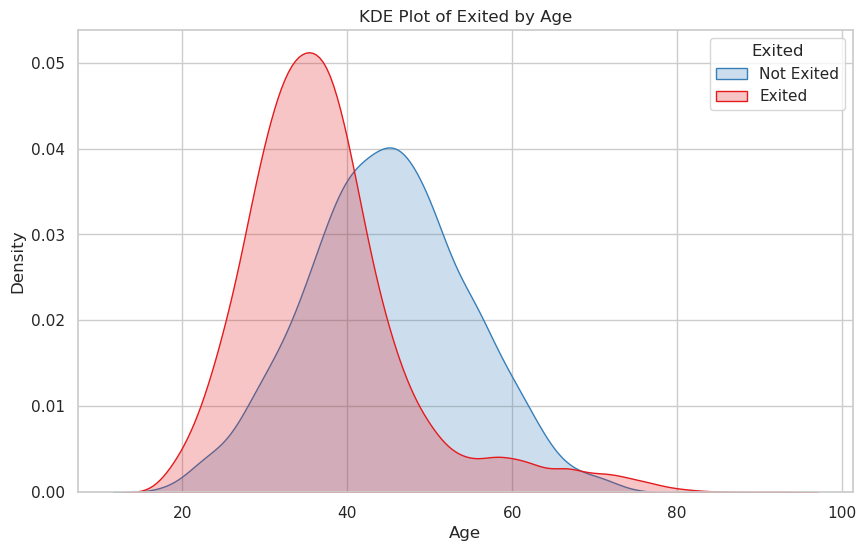

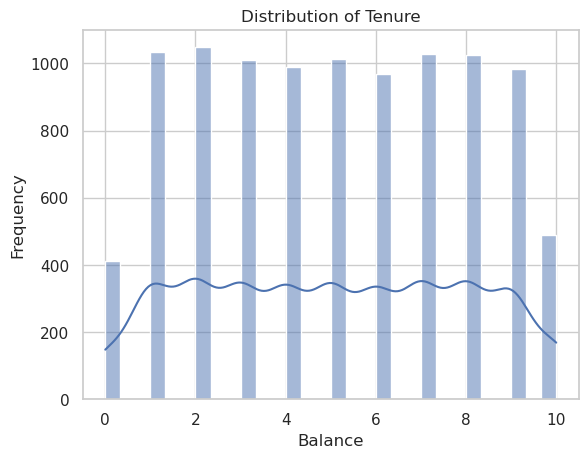

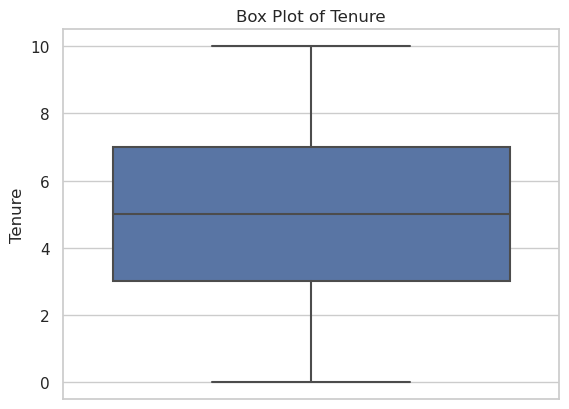

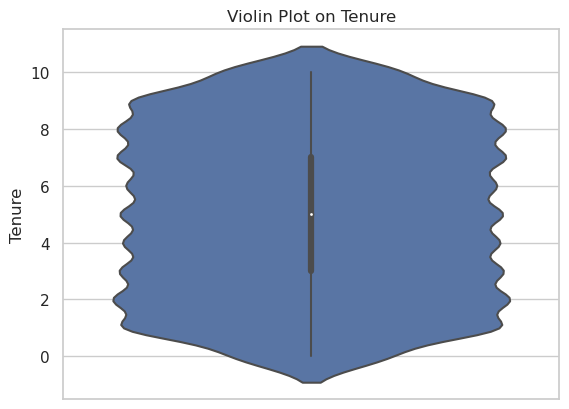

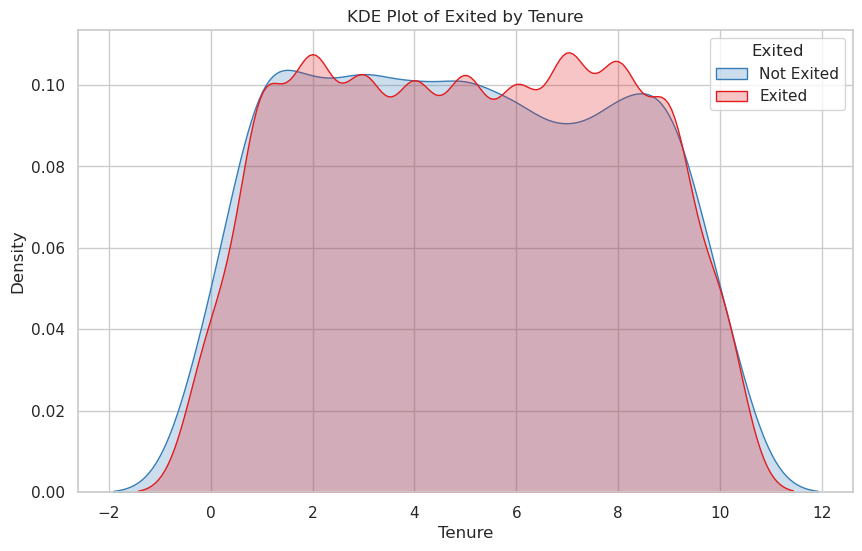

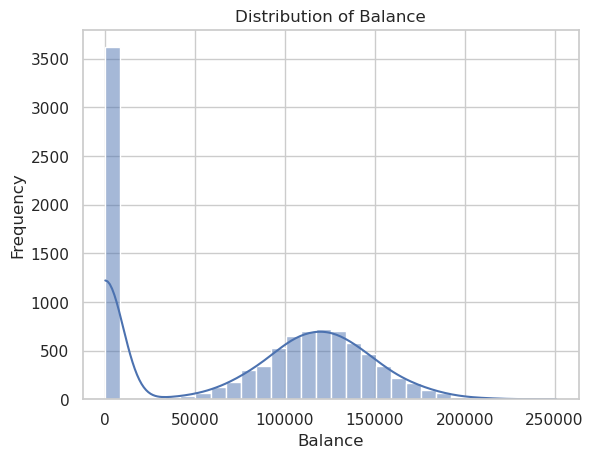

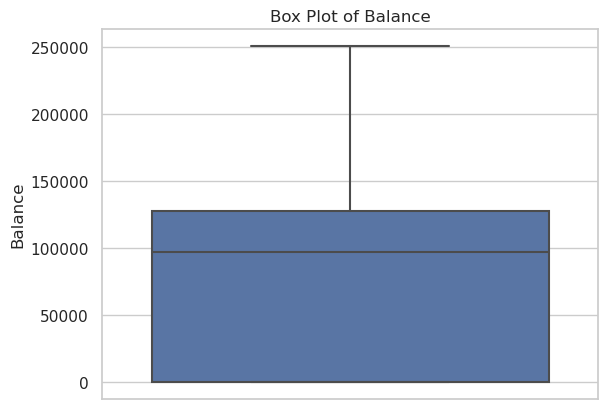

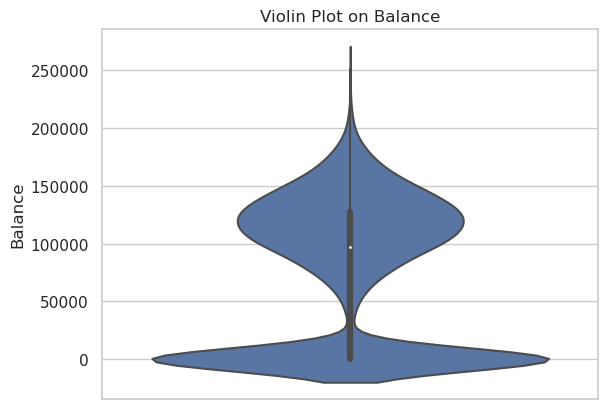

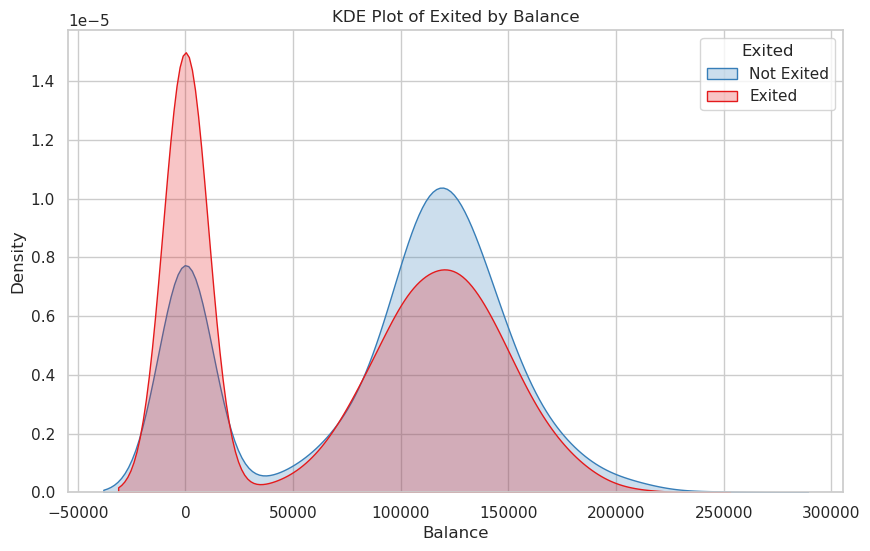

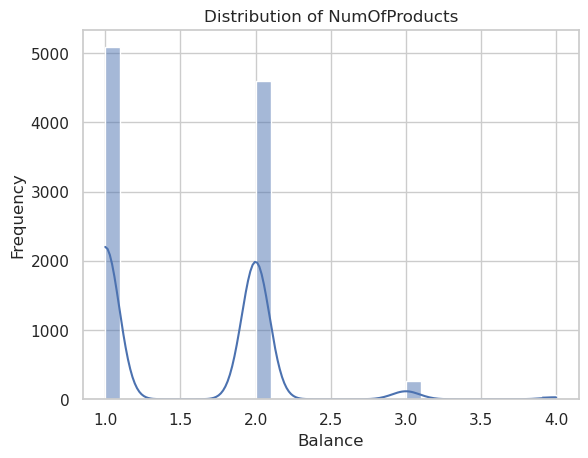

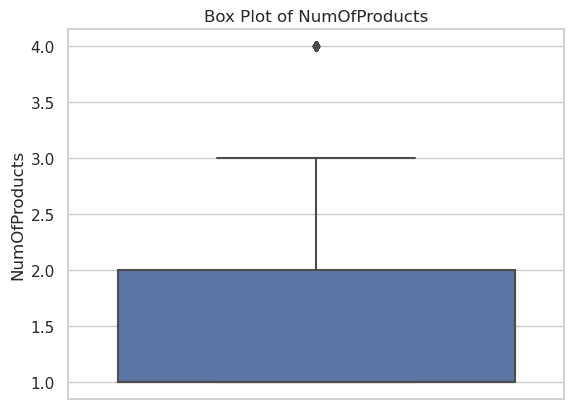

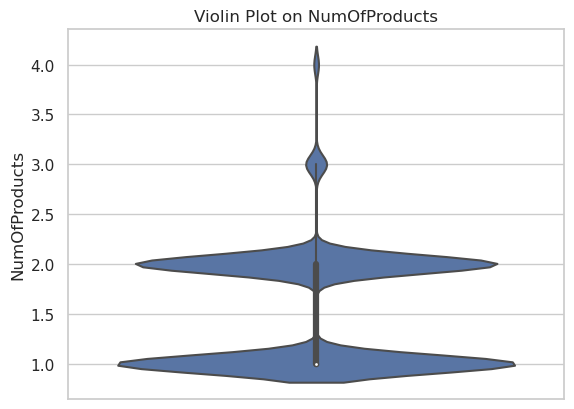

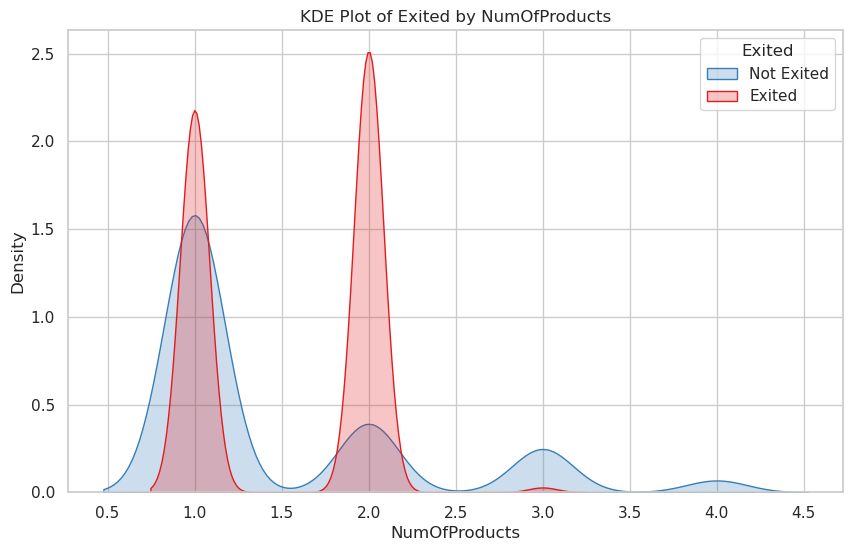

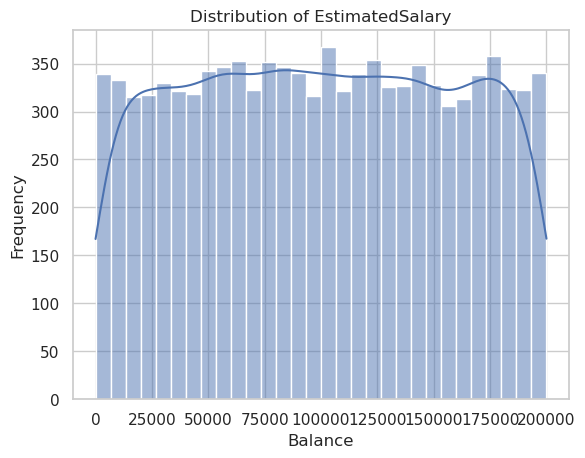

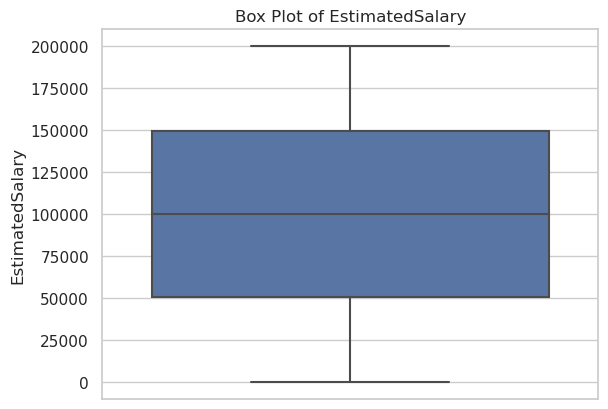

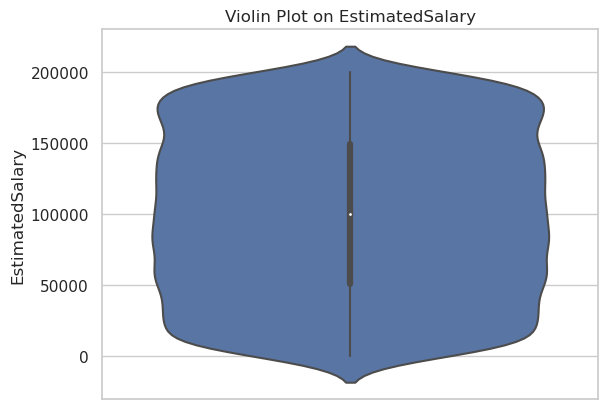

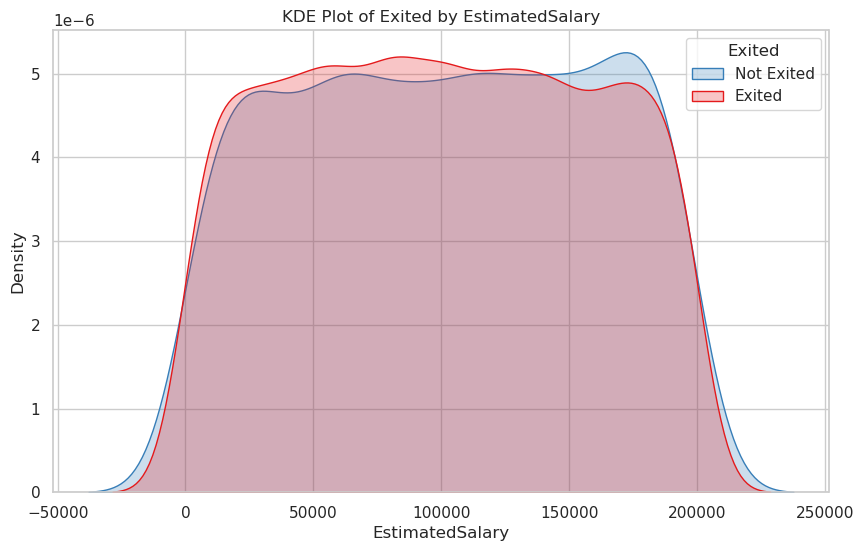

In [95]:
for name in interested_columns:
    plot_all(data,name,'Exited')

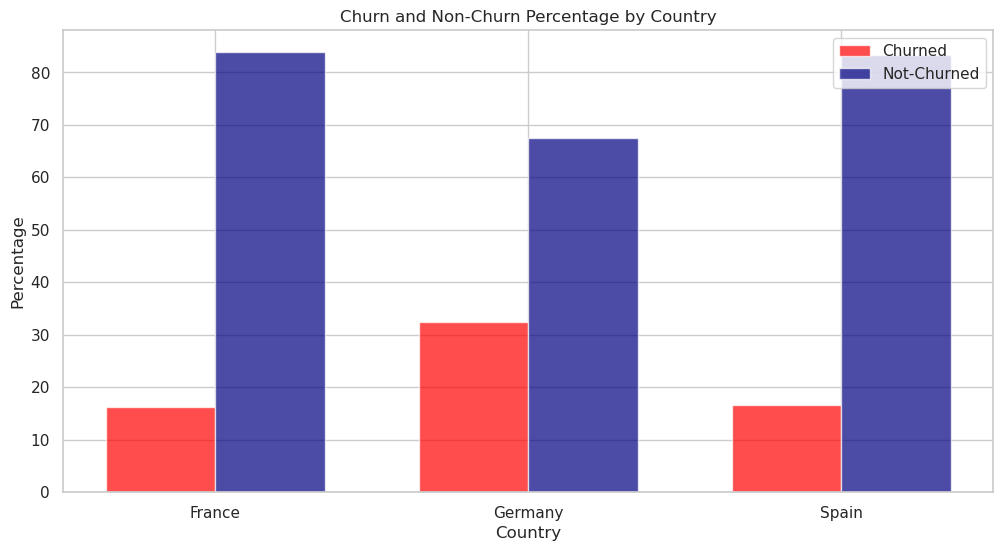

In [96]:
# Replace 1 with 'Yes' and 0 with 'No' in the 'Exited' column
data1['Exited'] = data1['Exited'].replace({1: 'Yes', 0: 'No'})

# Calculate the total count of customers in each country
total_customers_per_country = data1.groupby('Geography').size()

# Calculate the percentages of 'Yes' and 'No' within each country
percentage_data = (
    data1.groupby(['Geography', 'Exited']).size() / total_customers_per_country
).unstack(fill_value=0) * 100

# Create a side-by-side bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Define bar width and positions for side-by-side bars
bar_width = 0.35
index = range(len(percentage_data.reset_index()))

# Plot data
plt.bar(index, percentage_data['Yes'], bar_width, label='Churned', color='red', alpha=0.7)
plt.bar([i + bar_width for i in index], percentage_data['No'], bar_width, label='Not-Churned', color='navy', alpha=0.7)

plt.xlabel('Country')
plt.ylabel('Percentage')
plt.title('Churn and Non-Churn Percentage by Country')
plt.xticks([i + bar_width/2 for i in index], percentage_data.reset_index()['Geography'])
plt.legend(loc='upper right')
plt.show()

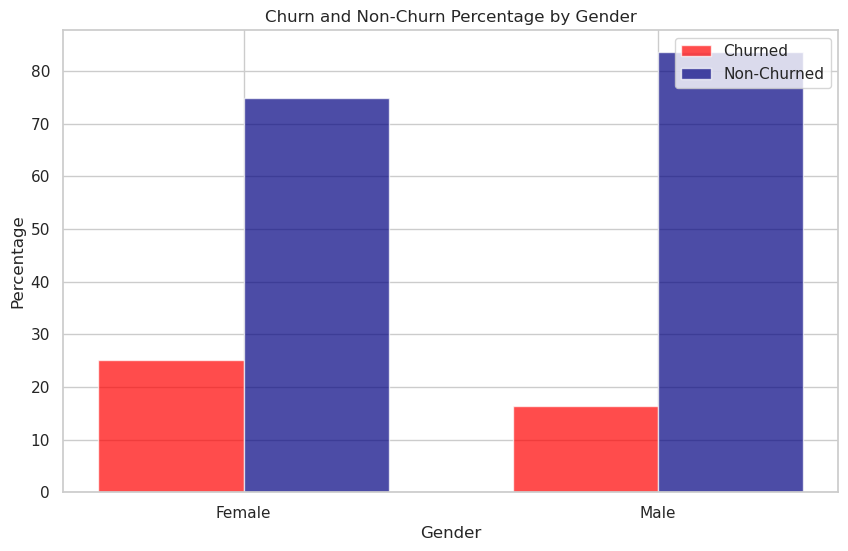

In [97]:
# Replace 0 with 'Male' and 1 with 'Female' in the 'Gender' column
data1['Gender'] = data1['Gender'].replace({0: 'Male', 1: 'Female'})

# Calculate the total count of customers for each gender
total_customers_per_gender = data1.groupby('Gender').size()

# Calculate the percentages of 'Yes' and 'No' within each gender
percentage_data = (
    data1.groupby(['Gender', 'Exited']).size() / total_customers_per_gender
).unstack(fill_value=0) * 100

# Create a side-by-side bar plot for gender
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Define bar width and positions for side-by-side bars
bar_width = 0.35
index = range(len(percentage_data.reset_index()))

# Plot data
plt.bar(index, percentage_data['Yes'], bar_width, label='Churned', color='red', alpha=0.7)
plt.bar([i + bar_width for i in index], percentage_data['No'], bar_width, label='Non-Churned', color='Navy', alpha=0.7)

plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Churn and Non-Churn Percentage by Gender')
plt.xticks([i + bar_width/2 for i in index], percentage_data.reset_index()['Gender'])
plt.legend(loc='upper right')
plt.show()

Interesting trend with accounts from Germany. Also important to note that more females are churning than males. The age distribution plot is skewed and that we can perform some feature engineering on Balance and number of products purchased.

In [98]:
# for heatmap of data
def make_heatmap(data):
    plt.figure(figsize=(10,12))
    sns.heatmap(data.corr(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.show()
    return

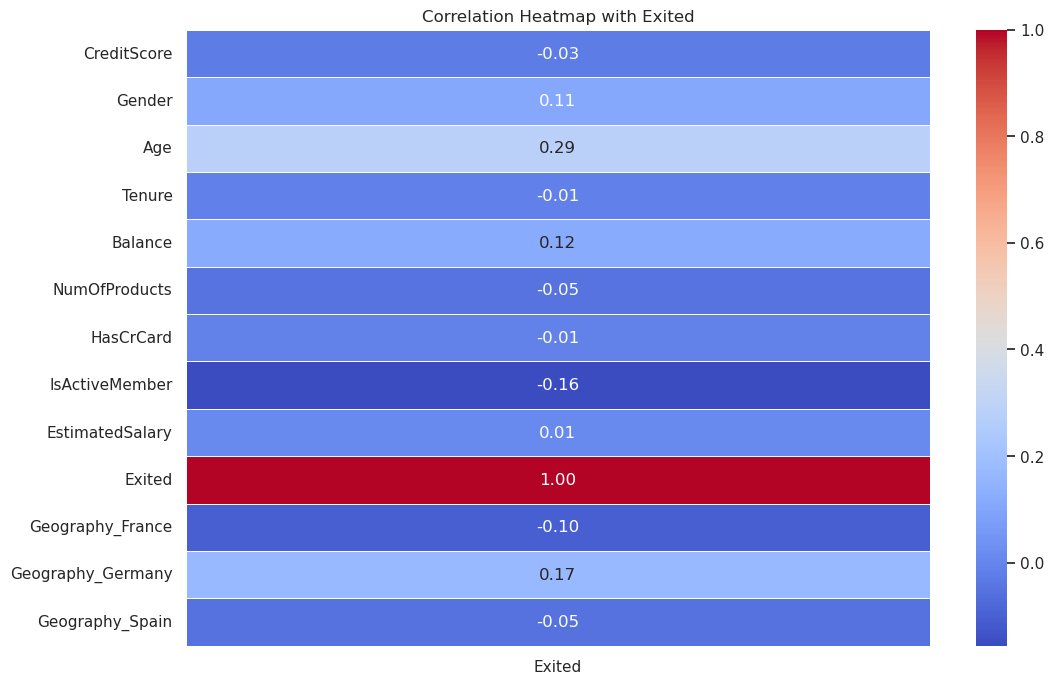

In [99]:
# checking correlation
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['Exited']], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap with Exited')
plt.show()

In [100]:
def corr_func(data):

    # Assuming 'df' is your DataFrame
    correlation_matrix = data.corr()

    # Calculate the correlation between "Exited" and other features
    corr_matrix = correlation_matrix['Exited'].drop('Exited')
    corr_table = corr_matrix.sort_values(ascending=False)
    return corr_table

corr_func(data)

Age                  0.285323
Geography_Germany    0.173488
Balance              0.118533
Gender               0.106512
EstimatedSalary      0.012097
HasCrCard           -0.007138
Tenure              -0.014001
CreditScore         -0.027094
NumOfProducts       -0.047820
Geography_Spain     -0.052667
Geography_France    -0.104955
IsActiveMember      -0.156128
Name: Exited, dtype: float64

## Feature Engineering

In [101]:
# Test feature skewness
print('Skewness')
headers = data.columns
for h in headers:
    print(f'{h}: {data[h].skew()}')

Skewness
CreditScore: -0.07160660820092675
Gender: 0.18359591003968673
Age: 1.0113202630234552
Tenure: 0.01099145797717904
Balance: -0.14110871094154384
NumOfProducts: 0.7455678882823168
HasCrCard: -0.9018115952400578
IsActiveMember: -0.06043662833499078
EstimatedSalary: 0.0020853576615585162
Exited: 1.4716106649378211
Geography_France: -0.005600862116454181
Geography_Germany: 1.1493403288111903
Geography_Spain: 1.1691059310324612


Of headers that are floats, age is heavily skewed. We can fix this with a log transformation.

In [102]:
data["Age"] = np.log(data["Age"])

Next I did more feature engineering as indicated by two specific classes in Balance and NumOfProducts features.

In [103]:
# feature engineering for Number of Products (==1 >= 2 products bought ==0 < 2 products bought)
#data['2+products'] = data['NumOfProducts'].apply(lambda x: 1 if x >= 2 else 0)
#data['<2products'] = data['NumOfProducts'].apply(lambda x: 0 if x >= 2 else 1)
#
## feature engineering for Balance (==1 >= 10000, ==0 < 10000)
#data['ZeroBalance'] = data['Balance'].apply(lambda x: 1 if x <=0 else 0)
#data['+Balance'] = data['Balance'].apply(lambda x: 1 if x >0 else 0)
#
## drop data no longer needed
#data = data.drop(columns=['NumOfProducts'])
#data = data.drop(columns=['Balance'])

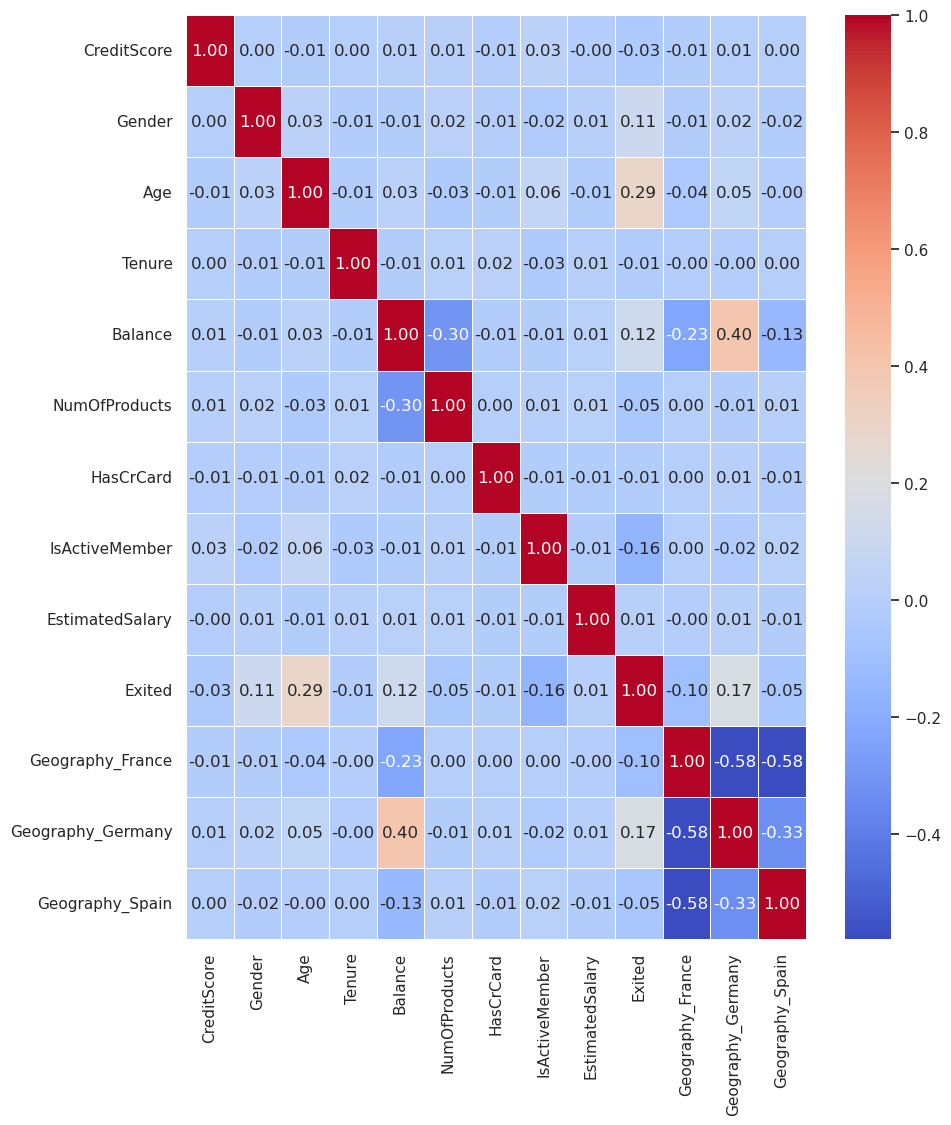

Age                  0.294082
Geography_Germany    0.173488
Balance              0.118533
Gender               0.106512
EstimatedSalary      0.012097
HasCrCard           -0.007138
Tenure              -0.014001
CreditScore         -0.027094
NumOfProducts       -0.047820
Geography_Spain     -0.052667
Geography_France    -0.104955
IsActiveMember      -0.156128
Name: Exited, dtype: float64

In [104]:
make_heatmap(data)
corr_func(data)

In [105]:
columns_to_scale = ['Balance','EstimatedSalary', 'CreditScore']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])
data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,0.538,1,3.737670,2,0.000000,1,1,1,0.506735,1,1,0,0
1,0.516,1,3.713572,1,0.334031,1,0,1,0.562709,0,0,0,1
2,0.304,1,3.737670,8,0.636357,3,1,0,0.569654,1,1,0,0
3,0.698,1,3.663562,1,0.000000,2,0,0,0.469120,0,1,0,0
4,1.000,1,3.761200,2,0.500246,1,1,1,0.395400,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.842,0,3.663562,5,0.000000,2,1,0,0.481341,0,1,0,0
9996,0.332,0,3.555348,10,0.228657,1,1,1,0.508490,0,1,0,0
9997,0.718,1,3.583519,7,0.000000,1,0,1,0.210390,1,1,0,0
9998,0.844,0,3.737670,3,0.299226,2,1,0,0.464429,1,0,1,0


## Balancing the dataset - SMOTE

In [106]:
# Chaecking to make sure the data set is balanced
data.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Our data set is imbalanced!!!

<Axes: >

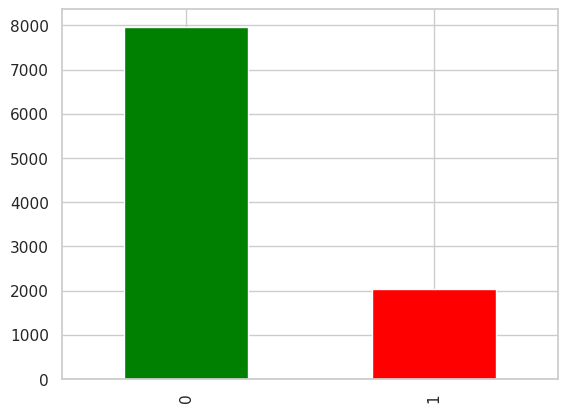

In [107]:
# Visualize the count for each class
data['Exited'].value_counts().plot.bar(color=['green', 'red'])

Let's first try a standard linear regression

In [108]:
# split the data
X_train, X_test, y_train, y_test = class_train_test_split(data, 'Exited', test_size=0.2, random_state=123)

In [109]:
# logistic regression model
# Build a simple logistic regression model
model = LogisticRegression(random_state=123, 
                              max_iter = 1000)

# Train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Classification Report:\n", report)
result_metrics(y_test,y_pred)

Test Accuracy: 0.8145
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      1586
           1       0.64      0.24      0.35       414

    accuracy                           0.81      2000
   macro avg       0.73      0.60      0.62      2000
weighted avg       0.79      0.81      0.78      2000

Accuracy is: 0.81
Precision is: 0.64
Recall is: 0.24
Fscore is: 0.25
AUC is: 0.60


Now let's try SMOTE

In [110]:
# Create a SMOTE sampler
rs = 123
smote_sampler = SMOTE(sampling_strategy='auto', k_neighbors=1, random_state = rs)

# Resample training data using SMOTE
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

<Axes: >

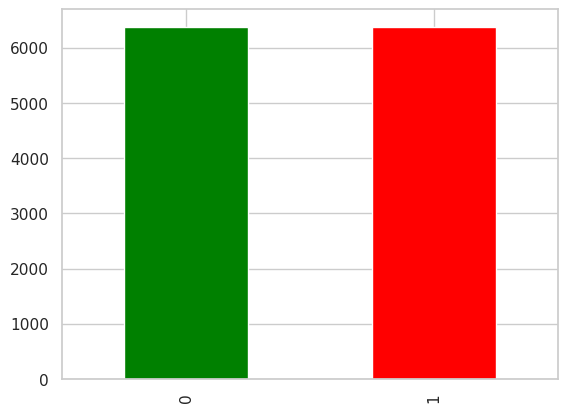

In [111]:
# Visualize classes after resampling
y_smo.value_counts().plot.bar(color=['green', 'red'])

In [112]:
# Training logistic regression
model.fit(X_smo, y_smo)
y_pred = model.predict(X_test)

In [113]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Classification Report:\n", report)
result_metrics(y_test, y_pred)

Test Accuracy: 0.7055
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.70      0.79      1586
           1       0.39      0.74      0.51       414

    accuracy                           0.71      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.80      0.71      0.73      2000

Accuracy is: 0.71
Precision is: 0.39
Recall is: 0.74
Fscore is: 0.72
AUC is: 0.72


So SMOTE has not necessarily improved our model. In some ways the accuracy is better, and in others it is worse. Let's try a random forest classifier to tune the hyper parameters

### Hyper Parameter Tuning - GridCV

In [114]:
def grid_hyper_tuner(X_train, y_train, classifier, params, n_jobs):

    # grid search
    grid_search = GridSearchCV(estimator=classifier, param_grid=params, cv=5, n_jobs=n_jobs, scoring='accuracy')
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters and best estimator
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    best_score = grid_search.best_score_
    print("Best Hyperparameters:", best_params)
    print("Best Estimator:", best_estimator)
    print("Best Cross-Validation Score:", best_score)
    print()
    
    # scores for each fold
    scores = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring='accuracy')
    print(scores)

    return best_params, best_estimator

### Random Forest Classifier

In [123]:
# Create a SMOTE sampler
rs = 123
n_jobs = 12

# Define the hyperparameters and their possible values to search over
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# create RFC model
RFC = RandomForestClassifier(random_state=rs)
best_params, best_estimator = grid_hyper_tuner(X_smo, y_smo, RFC, param_grid, n_jobs)

# use the best estimator to fit the data
RFC = RandomForestClassifier(**best_params, random_state=rs)
RFC.fit(X_smo, y_smo)

# predict
y_pred = best_estimator.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Classification Report:\n", report)
result_metrics(y_test,y_pred)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Estimator: RandomForestClassifier(max_depth=20, n_estimators=200, random_state=123)
Best Cross-Validation Score: 0.9043453009584862

[0.83967072 0.90239122 0.93649549 0.91885535 0.92431373]
Test Accuracy: 0.8335
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      1586
           1       0.60      0.59      0.59       414

    accuracy                           0.83      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.83      0.83      0.83      2000

Accuracy is: 0.83
Precision is: 0.60
Recall is: 0.59
Fscore is: 0.59
AUC is: 0.74


## Gradient Boosting

In [124]:
# parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.7, 0.8, 0.9]
}

# define classifier and gridsearchCV
GBC = GradientBoostingClassifier(random_state=rs)
best_params, best_estimator = grid_hyper_tuner(X_smo, y_smo, GBC, param_grid, n_jobs)

# use the best estimator to fit the data
best_estimator.fit(X_smo, y_smo)

# predict
y_pred = best_estimator.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Classification Report:\n", report)
result_metrics(y_test,y_pred)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.9}
Best Estimator: GradientBoostingClassifier(max_depth=7, min_samples_split=5, n_estimators=300,
                           random_state=123, subsample=0.9)
Best Cross-Validation Score: 0.8902349712915351

[0.70129361 0.90866327 0.95256762 0.94159153 0.94705882]
Test Accuracy: 0.8525
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      1586
           1       0.67      0.56      0.61       414

    accuracy                           0.85      2000
   macro avg       0.78      0.74      0.76      2000
weighted avg       0.84      0.85      0.85      2000

Accuracy is: 0.85
Precision is: 0.67
Recall is: 0.56
Fscore is: 0.56
AUC is: 0.74


## Decision Tree Classifier

In [122]:
param_grid = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

# define classifier and gridsearchCV
DTC = DecisionTreeClassifier()
best_params, best_estimator = grid_hyper_tuner(X_smo, y_smo, DTC, param_grid, n_jobs)

# use the best estimator to fit the data
best_estimator.fit(X_smo, y_smo)

# predict
y_pred = best_estimator.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Test Accuracy:", accuracy)
print("Classification Report:\n", report)
result_metrics(y_test,y_pred)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Estimator: DecisionTreeClassifier(criterion='entropy', max_features='auto')
Best Cross-Validation Score: 0.8365243310966095

[0.77107017 0.84319875 0.86475892 0.84084673 0.84470588]
Test Accuracy: 0.7625
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.85      1586
           1       0.44      0.53      0.48       414

    accuracy                           0.76      2000
   macro avg       0.66      0.68      0.66      2000
weighted avg       0.78      0.76      0.77      2000

Accuracy is: 0.76
Precision is: 0.44
Recall is: 0.53
Fscore is: 0.53
AUC is: 0.68
